Checking and understandig the data I am working with.

In [ ]:
import pandas as pd
import numpy as np

URL='https://raw.githubusercontent.com/Patrick0481/Individual-project/refs/heads/main/activities.csv'
Strava_df = pd.read_csv(URL)

Strava_df.head()

In [ ]:
Strava_df.info()
Strava_df.describe()

In [49]:
# Remove columns with all NaN values
print(f"Column count for cleanup: {len(Strava_df.columns)}")

# Clean the DataFrame by dropping columns with all NaN values
Strava_df = Strava_df.dropna(axis=1, how='all')

# Final overview
print(f"Columns after cleaning: {len(Strava_df.columns)}")
print(Strava_df.info())

Column count for cleanup: 65
Columns after cleaning: 65
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Activity ID                  1172 non-null   int64         
 1   Activity Date                1172 non-null   datetime64[ns]
 2   Activity Name                1172 non-null   object        
 3   Activity Type                1172 non-null   object        
 4   Activity Description         266 non-null    object        
 5   Elapsed Time                 1172 non-null   int64         
 6   Distance                     1172 non-null   float64       
 7   Max Heart Rate               1091 non-null   float64       
 8   Relative Effort              1091 non-null   float64       
 9   Commute                      1172 non-null   bool          
 10  Activity Gear                544 non-null    object 

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error


In [47]:
# Convert Distance from Meters to Kilometers
if Strava_df['Distance'].mean() > 100:
    print("Converting Distance from Meters to Km...")
    Strava_df['Distance'] = Strava_df['Distance'] / 1000

# Convert Time from Seconds to Minutes
if Strava_df['Moving Time'].mean() > 300:
    print("Converting Time from Seconds to Minutes...")
    Strava_df['Moving Time'] = Strava_df['Moving Time'] / 60

print(f"Average Distance: {Strava_df['Distance'].mean():.2f} km")
print(f"Average Time: {Strava_df['Moving Time'].mean():.2f} min")
    
import datetime as dt

if 'Activity Date' in Strava_df.columns:
    # Ensure it's in datetime format
    Strava_df['Activity Date'] = pd.to_datetime(Strava_df['Activity Date'])
    
    # Create the numeric date (converts date to a number like 738900)
    Strava_df['Date_Numeric'] = Strava_df['Activity Date'].map(dt.datetime.toordinal)



Average Distance: 9.40 km
Average Time: 42.74 min


In [ ]:
#The model 

import pandas as pd

# Filter for decent runs (> 3km) with Heart Rate
df_clean = Strava_df[(Strava_df['Distance'] > 3.0) & (Strava_df['Average Heart Rate'] > 0)].copy()
df_clean = df_clean.dropna(subset=['Average Heart Rate'])

# Calculate Speed (km/h)
df_clean['Speed_kmh'] = df_clean['Distance'] / (df_clean['Moving Time'] / 60)

# Remove "Superhuman" speeds  (22 km/h is ~2:45 min/km pace)
df_clean = df_clean[df_clean['Speed_kmh'] < 22]

print(f"Cleaned data: {len(df_clean)} valid runs remaining.")

# EF = How much Speed you get for every 1 BPM of Heart Rate
df_clean['Efficiency'] = df_clean['Speed_kmh'] / df_clean['Average Heart Rate']

# We take the 95th percentile (Top 5%) to find your best potential, 
# ignoring absolute outliers/glitches.
best_efficiency = df_clean['Efficiency'].quantile(0.95)

# 4. Predict
max_hr = 195
pred_speed_kmh = best_efficiency * max_hr

# Convert to Time and Pace
pred_time_5k = (5.0 / pred_speed_kmh) * 60
pred_pace_min = 60 / pred_speed_kmh
pace_sec = int((pred_pace_min % 1) * 60)


print(f"--- 5km Prediction (Efficiency Method) ---")
print(f"Based on your Top 5% most efficient runs.")
print(f"Max Heart Rate: {max_hr}")
print(f"Predicted Speed: {pred_speed_kmh:.2f} km/h")
print(f"Predicted Pace:  {int(pred_pace_min)}:{pace_sec:02d} min/km")
print(f"Predicted Time:  {pred_time_5k:.2f} minutes")

Cleaned data: 884 valid runs remaining.
--- 5km Prediction (Efficiency Method) ---
Based on your Top 5% most efficient runs.
Max Heart Rate: 195
Predicted Speed: 18.17 km/h
Predicted Pace:  3:18 min/km
Predicted Time:  16.51 minutes


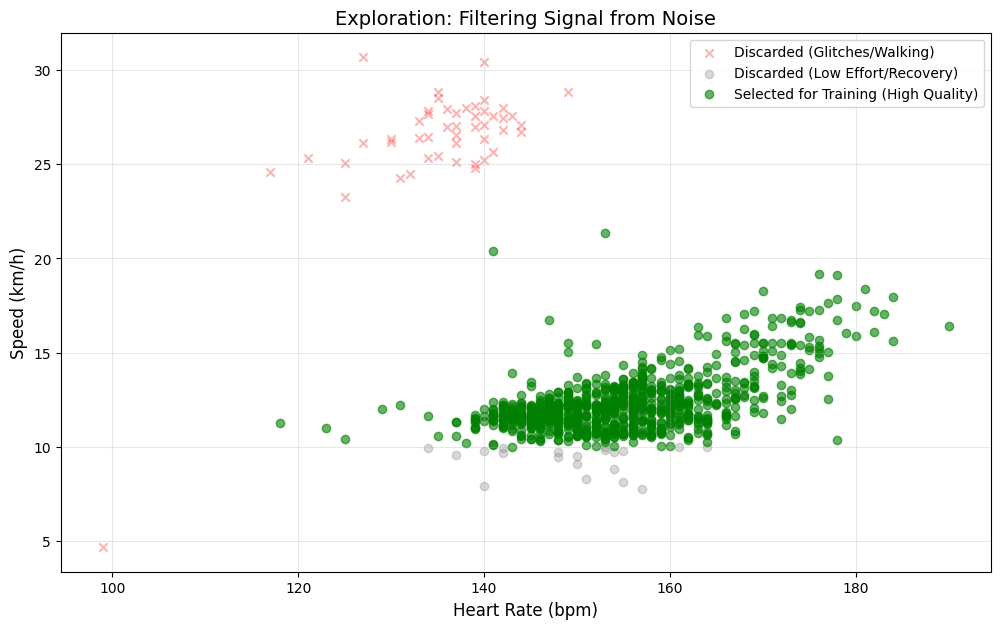

In [46]:
import matplotlib.pyplot as plt

#checking whitch data to use for model training

# We look at everything > 3km
df_exp = Strava_df[(Strava_df['Distance'] > 3.0) & (Strava_df['Average Heart Rate'] > 0)].copy()

# Calculate Speed
df_exp['Speed_kmh'] = df_exp['Distance'] / (df_exp['Moving Time'] / 60)

# 2. Apply the "Experimental Logic" to find the Best Data
# Criteria 1: Remove Glitches (> 22 km/h) and Walking (< 6 km/h)
# Criteria 2: Keep only runs with decent speed (e.g., > 10 km/h) for the "Model Data"
df_noise = df_exp[(df_exp['Speed_kmh'] >= 22) | (df_exp['Speed_kmh'] <= 6)]
df_slow  = df_exp[(df_exp['Speed_kmh'] < 10) & (df_exp['Speed_kmh'] > 6)]
df_model = df_exp[(df_exp['Speed_kmh'] >= 10) & (df_exp['Speed_kmh'] < 22)]

# 3. Plot the "Experimentation Result"
plt.figure(figsize=(12, 7))

# Plot Rejected Data (Noise)
plt.scatter(df_noise['Average Heart Rate'], df_noise['Speed_kmh'], 
            color='red', alpha=0.3, marker='x', label='Discarded (Glitches/Walking)')

# Plot Slow Data (Low Effort - Not useful for Race Prediction)
plt.scatter(df_slow['Average Heart Rate'], df_slow['Speed_kmh'], 
            color='grey', alpha=0.3, label='Discarded (Low Effort/Recovery)')

# Plot Selected Data (The "Gold" used for the Model)
plt.scatter(df_model['Average Heart Rate'], df_model['Speed_kmh'], 
            color='green', alpha=0.6, label='Selected for Training (High Quality)')

plt.title('Exploration: Filtering Signal from Noise', fontsize=14)
plt.xlabel('Heart Rate (bpm)', fontsize=12)
plt.ylabel('Speed (km/h)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()